## Linear & Non-Linear Models - Homework #4
### Luke Schwenke
### February 15, 2023

In [61]:
import os
import pandas as pd
import seaborn as sea
import numpy as np
import math
from patsy import dmatrices
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import glm

In [62]:
os.getcwd()
os.chdir('/Users/lmschwenke/Downloads')

In [63]:
df = pd.read_csv('ER_visit.csv')
df.head(10)

,car,outdoor_activity,chronic_disease,household_history,gym,ER_visit
0,1,0.0,0.0,1,0,0
1,0,1.0,1.0,1,0,0
2,0,1.0,0.0,1,0,0
3,0,1.0,1.0,2,1,0
4,0,1.0,0.0,1,0,1
5,0,1.0,1.0,4,2,0
6,0,1.0,0.0,3,1,0
7,0,1.0,0.0,4,3,0
8,1,0.0,1.0,3,2,0
9,0,1.0,1.0,1,0,1


## A - Seaborn Dist. Plot

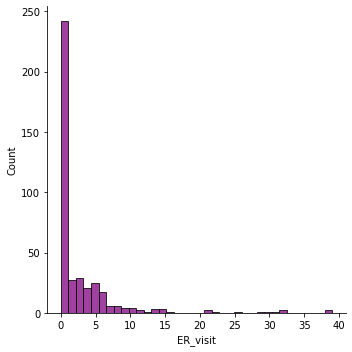

In [64]:
sea.displot(df['ER_visit'], color='purple')
plt.show()

## B - Poisson

In [65]:
model = glm('ER_visit ~ car + outdoor_activity + chronic_disease + household_history + gym', data = df, family = sm.families.Poisson()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               ER_visit   No. Observations:                  402
Model:                            GLM   Df Residuals:                      396
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1260.0
Date:                Tue, 14 Feb 2023   Deviance:                       1870.0
Time:                        15:26:02   Pearson chi2:                 2.50e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.8185
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.0747      0.12

In [66]:
np.exp(model.params)

Intercept            0.341408
car                  1.414269
outdoor_activity     1.727049
chronic_disease      1.013159
household_history    1.960575
gym                  0.503210
dtype: float64

### Poisson Interpretation

Since all the parameters are on the log scale we need to exponentiate to obtain the response function in terms of lambda.

* car - for a 1-unit increase in car the mean response (lambda) of ER visits will multiply by 1.41, or increase 41% in the estimated # of ER visits 
* outdoor_activity - for a 1-unit increase in outdoor activity the mean response (lambda) of ER visits will multiply by 1.73, or increase 73% in the estimated # of ER visits
* chronic_disease - for a 1-unit increase in chronic disease the mean response (lambda) of ER visits will multiply by 1.01, or increase 1% in the estimated # of ER visits
* household_history - for a 1-unit increase in household history the mean response (lambda) of ER visits will multiply by 1.86, or increase 96% in the estimated # of ER visits
* gym - for a 1-unit increase in gym the mean response (lambda) of ER visits will multiply by 0.5

## C - Negative Binomial

In [67]:
neg_binom = glm('ER_visit ~ car + outdoor_activity + chronic_disease + household_history + gym', data = df,family = sm.families.NegativeBinomial(alpha = 0.94)).fit()
print(neg_binom.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               ER_visit   No. Observations:                  402
Model:                            GLM   Df Residuals:                      396
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -776.10
Date:                Tue, 14 Feb 2023   Deviance:                       566.12
Time:                        15:26:02   Pearson chi2:                     816.
No. Iterations:                    20   Pseudo R-squ. (CS):             0.4233
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.0388      0.25

In [68]:
np.exp(neg_binom.params)

Intercept            0.130185
car                  2.392984
outdoor_activity     3.363810
chronic_disease      0.995697
household_history    2.054253
gym                  0.410256
dtype: float64

In [69]:
# OVERDISPERSION CALCULATION

# Compute and print sample mean 
er_mean = np.mean(df.ER_visit)
print('Sample mean:', round(er_mean, 2))

# Compute and print sample variance of the number of satellites: sat_var
er_var = np.var(df.ER_visit)
print('Sample variance:', round(er_var, 2))

# Compute ratio of variance to mean
print('Ratio:', round(er_var/er_mean, 3))
print('^ This oberserved effect is overdispersion')


poisson_dispersion_ratio = model.pearson_chi2/model.df_resid
print('The poisson dispersion ratio =', round(poisson_dispersion_ratio,3))

negbinom_dispersion_ratio = neg_binom.pearson_chi2/neg_binom.df_resid
print('The negative binomial dispersion ratio =', round(negbinom_dispersion_ratio,3))

Sample mean: 2.79
Sample variance: 29.48
Ratio: 10.57
^ This oberserved effect is overdispersion
The poisson dispersion ratio = 6.316
The negative binomial dispersion ratio = 2.06


### Differences Between Poisson & Negative Binomial

* When comparing the poisson model results with the negative binomial results we can see, in general, some of the negative binomial model parameters have a larger multiplicative effect on the mean response of ER visits (lambda). In other words, this model will predict higher chances of ER visits with the same variables. E.g., the poisson model had a 1 -unit increase in car increase the mean response by a multiple of 1.41, but the negative binomial shows it increasing by 2.39. 
* Other variables like chronic disease and gym actually have a lower multiplactive effect compared to their poisson counterpart. 
* Overall the models are giving varying weight to different parameters as they predict ER visits.

**Overdispersion**

* The poisson disperion ratio is 6.3
* The negative binomial dispersion ratio is 2.1
* Conclusion: Since both values are over 1, we can conlude that there is overdispersion for both models. This means that the mean is not equal to the variance and that the assumption that these values are equal is violated.


## D - Zero-Inflation

In [70]:
# Expected number of zero counts
ER_mean = np.mean(df['ER_visit'])
exp_zero_cnt = ((ER_mean**0)*np.exp(-ER_mean))/math.factorial(0)

# Print exp_zero_counts
print('Expected zero counts given mean of ', round(ER_mean,3), 
      'is ', round(exp_zero_cnt,3)*100)

# Number of zero counts in ER_visit variable
actual_zero_ant = sum(df['ER_visit'] == 0)

# Number of observations in dataset
num_obs = len(df)

# Print the percentage of zero count observations in the sample
print('Actual zero counts in the sample: ', round(actual_zero_ant / num_obs,3)*100)

Expected zero counts given mean of  2.789 is  6.2
Actual zero counts in the sample:  48.5


We would expect our zero counts to be 6.2 given an ER visit mean value of 2.789%. This is much lower than the actual zero counts in the sample at 48.5%

## E - Training Zero-Inflated Poisson

In [74]:
np.random.seed(42)

tst = np.random.rand(len(df)) < 0.8
df_train = df[tst]
df_test = df[~tst]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

# Create model expression
expr = 'ER_visit ~ car + outdoor_activity + chronic_disease + household_history + gym'

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

# Fit Zero Inflated Poisson
zip_training_results = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train, exog_infl=X_train, inflation='logit').fit()

print(zip_training_results.summary())

Training data set length=320
Testing data set length=82
         Current function value: 2.135406
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                ER_visit   No. Observations:                  320
Model:             ZeroInflatedPoisson   Df Residuals:                      314
Method:                            MLE   Df Model:                            5
Date:                 Tue, 14 Feb 2023   Pseudo R-squ.:                  0.2476
Time:                         15:33:08   Log-Likelihood:                -683.33
converged:                       False   LL-Null:                       -908.16
Covariance Type:             nonrobust   LLR p-value:                 5.841e-95
                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

/Users/lmschwenke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lmschwenke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [75]:
zip_predictions = zip_training_results.predict(X_test, exog_infl=X_test)
predicted_counts=np.round(zip_predictions)
actual_counts = y_test['ER_visit']

print('ZIP RMSE='+str(np.sqrt(np.sum(np.power(np.subtract(predicted_counts, actual_counts),2)))))

ZIP RMSE=37.36308338453881


**RMSE of Zero Inflated Poisson** = 37.36

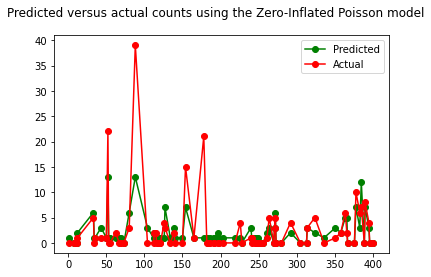

In [76]:
fig = plt.figure()
fig.suptitle('Predicted versus actual counts using the Zero-Inflated Poisson model')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual')
plt.legend(handles=[predicted, actual])
plt.show()